# Notebook 04 — Train/Hold-out Evaluation & Fehleranalyse (Anforderungen 7–8)

**Input:** `data/processed/model_ready.csv`  
**Target:** `moving_time` (Sekunden)

Ziele:
- Train/Test Split (Hold-out) als finaler “Reality Check”
- Training des Baseline-Modells: **Poly2 + Ridge (alpha=1e-4)** mit NO-LEAK Features
- Evaluation auf Hold-out: **MAE, RMSE, R²**
- Fehleranalyse: Residuen, typische Fehlermuster, Auffälligkeiten

**Output:**
- Metriken als CSV nach `data_derived/`
- Plots nach `plots/`


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 42
np.random.seed(SEED)

CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

PATH_MODEL_READY = REPO_ROOT / "data" / "processed" / "model_ready.csv"
PATH_PLOTS = REPO_ROOT / "plots"
PATH_DERIVED = REPO_ROOT / "data_derived"

PATH_PLOTS.mkdir(parents=True, exist_ok=True)
PATH_DERIVED.mkdir(parents=True, exist_ok=True)

def savefig(filename: str) -> None:
    out = PATH_PLOTS / filename
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")

def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


In [2]:
if not PATH_MODEL_READY.exists():
    raise FileNotFoundError(f"model_ready.csv not found at: {PATH_MODEL_READY}")

df = pd.read_csv(PATH_MODEL_READY)
print("Loaded model_ready:", df.shape)
display(df.head())

TARGET = "moving_time"

FEATURES_NO_LEAK = [c for c in [
    "distance",
    "total_elevation_gain",
    "highest_elevation",
    "lowest_elevation",
] if c in df.columns]

print("FEATURES_NO_LEAK:", FEATURES_NO_LEAK)

X = df[FEATURES_NO_LEAK].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Loaded model_ready: (9039, 10)


,distance,elapsed_time,highest_elevation,lowest_elevation,moving_time,total_elevation_gain,stop_time,stop_ratio,avg_speed_implied_kmh,pace_min_per_km
0,102977.0,15212,476.6,241.6,14505,968.0,707,0.046476,25.557890,2.347612
1,64046.5,10964,394.8,221.2,9097,768.0,1867,0.170285,25.345433,2.367290
2,38853.7,5271,68.4,-27.4,5271,162.0,0,0.000000,26.536392,2.261046
3,39075.8,6634,57.8,-28.2,4813,79.0,1821,0.274495,29.227692,2.052848
4,51232.3,7491,228.6,-10.2,7491,608.0,0,0.000000,24.621049,2.436939


FEATURES_NO_LEAK: ['distance', 'total_elevation_gain', 'highest_elevation', 'lowest_elevation']
Train shape: (7231, 4) Test shape: (1808, 4)


## Hold-out Training & Evaluation

Wir trainieren das in Notebook 03 ausgewählte Modell auf dem Trainingssplit und evaluieren anschließend auf dem Testsplit.
Der Testsplit dient als unabhängiger Reality-Check (keine Hyperparameter-Entscheidungen mehr basierend auf dem Testset).


In [4]:
model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=1e-4, random_state=SEED)),
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrics = {
    "n_train": len(X_train),
    "n_test": len(X_test),
    "mae": mean_absolute_error(y_test, y_pred),
    "rmse": rmse(y_test, y_pred),
    "r2": r2_score(y_test, y_pred),
}

metrics_df = pd.DataFrame([metrics])
display(metrics_df)

metrics_df.to_csv(PATH_DERIVED / "31_holdout_metrics_no_leak.csv", index=False)


,n_train,n_test,mae,rmse,r2
0,7231,1808,752.029937,1316.866006,0.915537


In [5]:
pred_df = X_test.copy()
pred_df["y_true"] = y_test.values
pred_df["y_pred"] = y_pred
pred_df["residual"] = pred_df["y_true"] - pred_df["y_pred"]
pred_df["abs_error"] = pred_df["residual"].abs()

display(pred_df.head())
pred_df.to_csv(PATH_DERIVED / "32_holdout_predictions_no_leak.csv", index=False)


,distance,total_elevation_gain,highest_elevation,lowest_elevation,y_true,y_pred,residual,abs_error
1188,12367.8,31.9,191.2,144.6,1544,2121.654560,-577.654560,577.654560
6182,8468.7,30.3,247.7,148.1,1362,1507.977177,-145.977177,145.977177
8359,10246.0,184.5,264.7,141.0,1769,2176.431237,-407.431237,407.431237
3614,29210.2,595.1,546.2,147.0,9303,5641.676972,3661.323028,3661.323028
8765,74478.3,1828.6,666.0,157.0,11433,14775.159981,-3342.159981,3342.159981


## Fehleranalyse (Hold-out)

Wir untersuchen:
- Wie gut stimmen Vorhersage und Wahrheit insgesamt überein? (y_true vs y_pred)
- Gibt es systematische Fehler bei kurzen/lange Distanzen oder bei viel Höhenmetern?
- Welche Fälle haben besonders große Fehler (Top-Fehler) und warum?

Hinweis: Qualitätsmerkmale wie `stop_ratio` werden **nicht** als Features genutzt (Leakage), können aber zur Interpretation auffälliger Fälle herangezogen werden.


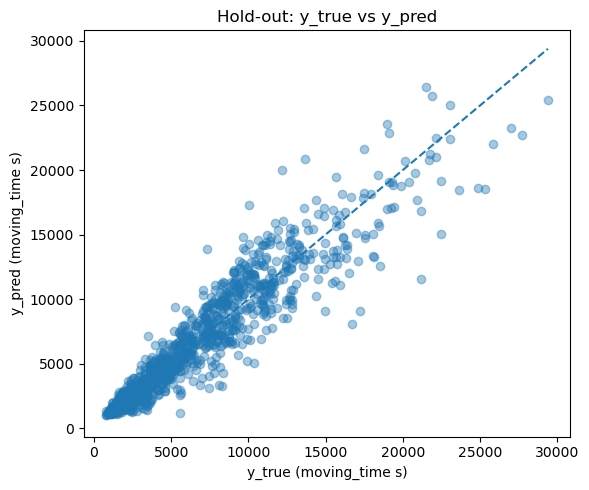

In [6]:
plt.figure(figsize=(6, 5))
plt.scatter(pred_df["y_true"], pred_df["y_pred"], alpha=0.4)
plt.xlabel("y_true (moving_time s)")
plt.ylabel("y_pred (moving_time s)")
plt.title("Hold-out: y_true vs y_pred")

# Reference line y=x
mn = min(pred_df["y_true"].min(), pred_df["y_pred"].min())
mx = max(pred_df["y_true"].max(), pred_df["y_pred"].max())
plt.plot([mn, mx], [mn, mx], linestyle="--")

savefig("31_holdout_ytrue_vs_ypred.png")
plt.show()


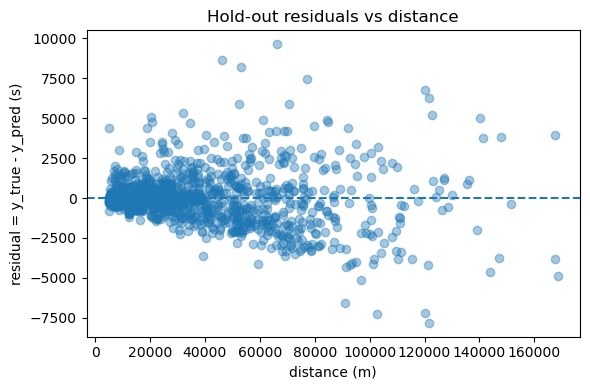

In [7]:
plt.figure(figsize=(6, 4))
plt.scatter(pred_df["distance"], pred_df["residual"], alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("distance (m)")
plt.ylabel("residual = y_true - y_pred (s)")
plt.title("Hold-out residuals vs distance")
savefig("32_holdout_residuals_vs_distance.png")
plt.show()


In [8]:
top_err = pred_df.sort_values("abs_error", ascending=False).head(25)
display(top_err)

top_err.to_csv(PATH_DERIVED / "33_top25_holdout_abs_error.csv", index=False)


,distance,total_elevation_gain,highest_elevation,lowest_elevation,y_true,y_pred,residual,abs_error
8490,66412.1,1127.0,903.2,119.2,21205,11573.175622,9631.824378,9631.824378
862,46159.6,643.3,453.2,145.1,16697,8076.800392,8620.199608,8620.199608
866,53057.1,584.9,323.7,150.6,17226,9043.092087,8182.907913,8182.907913
5359,121594.0,1441.0,300.2,113.4,12163,19974.398201,-7811.398201,7811.398201
333,77144.0,1660.5,464.2,143.0,22465,15027.673520,7437.326480,7437.326480
5646,102550.0,1065.4,248.0,202.4,10019,17310.072586,-7291.072586,7291.072586
5544,120160.0,2037.0,1371.4,519.0,13633,20825.497519,-7192.497519,7192.497519
1295,120222.0,1281.8,638.4,113.1,25328,18560.627305,6767.372695,6767.372695
5665,91054.8,761.7,692.3,100.3,7297,13856.692352,-6559.692352,6559.692352
3464,121597.0,1204.1,547.5,90.3,24871,18591.002141,6279.997859,6279.997859


In [9]:
# Add QC columns for interpretation (NOT for training)
qc_cols = ["elapsed_time", "stop_time", "stop_ratio", "avg_speed_implied_kmh", "pace_min_per_km"]
qc_cols = [c for c in qc_cols if c in df.columns]

# Merge QC features back to pred_df via index alignment
pred_qc = pred_df.join(df.loc[pred_df.index, qc_cols])

display(pred_qc.head())
pred_qc.to_csv(PATH_DERIVED / "34_holdout_predictions_with_qc.csv", index=False)


,distance,total_elevation_gain,highest_elevation,lowest_elevation,y_true,y_pred,residual,abs_error,elapsed_time,stop_time,stop_ratio,avg_speed_implied_kmh,pace_min_per_km
1188,12367.8,31.9,191.2,144.6,1544,2121.654560,-577.654560,577.654560,1654,110,0.066505,28.836839,2.080672
6182,8468.7,30.3,247.7,148.1,1362,1507.977177,-145.977177,145.977177,1398,36,0.025751,22.384229,2.680459
8359,10246.0,184.5,264.7,141.0,1769,2176.431237,-407.431237,407.431237,1941,172,0.088614,20.851102,2.877546
3614,29210.2,595.1,546.2,147.0,9303,5641.676972,3661.323028,3661.323028,14473,5170,0.357217,11.303528,5.308077
8765,74478.3,1828.6,666.0,157.0,11433,14775.159981,-3342.159981,3342.159981,15231,3798,0.249360,23.451577,2.558463


In [10]:
pred_qc["stop_ratio_gt_0_5"] = pred_qc["stop_ratio"] > 0.5

group_stats = pred_qc.groupby("stop_ratio_gt_0_5")[["abs_error", "residual"]].agg(
    abs_error_median=("abs_error", "median"),
    abs_error_mean=("abs_error", "mean"),
    residual_median=("residual", "median"),
    count=("abs_error", "size"),
).reset_index()

display(group_stats)
group_stats.to_csv(PATH_DERIVED / "35_error_by_stop_ratio_group.csv", index=False)


,stop_ratio_gt_0_5,abs_error_median,abs_error_mean,residual_median,count
0,False,298.819343,749.221762,-112.382296,1757
1,True,310.374494,848.774311,147.182185,51


In [11]:
top_err_qc = pred_qc.sort_values("abs_error", ascending=False).head(25)
cols_show = FEATURES_NO_LEAK + ["y_true", "y_pred", "residual", "abs_error"] + [c for c in ["stop_ratio", "stop_time", "elapsed_time"] if c in pred_qc.columns]
display(top_err_qc[cols_show])

top_err_qc[cols_show].to_csv(PATH_DERIVED / "36_top25_holdout_abs_error_with_qc.csv", index=False)


,distance,total_elevation_gain,highest_elevation,lowest_elevation,y_true,y_pred,residual,abs_error,stop_ratio,stop_time,elapsed_time
8490,66412.1,1127.0,903.2,119.2,21205,11573.175622,9631.824378,9631.824378,0.082710,1912,23117
862,46159.6,643.3,453.2,145.1,16697,8076.800392,8620.199608,8620.199608,0.412429,11720,28417
866,53057.1,584.9,323.7,150.6,17226,9043.092087,8182.907913,8182.907913,0.420020,12475,29701
5359,121594.0,1441.0,300.2,113.4,12163,19974.398201,-7811.398201,7811.398201,0.003278,40,12203
333,77144.0,1660.5,464.2,143.0,22465,15027.673520,7437.326480,7437.326480,0.129061,3329,25794
5646,102550.0,1065.4,248.0,202.4,10019,17310.072586,-7291.072586,7291.072586,0.000000,0,10019
5544,120160.0,2037.0,1371.4,519.0,13633,20825.497519,-7192.497519,7192.497519,0.000000,0,13633
1295,120222.0,1281.8,638.4,113.1,25328,18560.627305,6767.372695,6767.372695,0.196854,6208,31536
5665,91054.8,761.7,692.3,100.3,7297,13856.692352,-6559.692352,6559.692352,0.092639,745,8042
3464,121597.0,1204.1,547.5,90.3,24871,18591.002141,6279.997859,6279.997859,0.248837,8239,33110


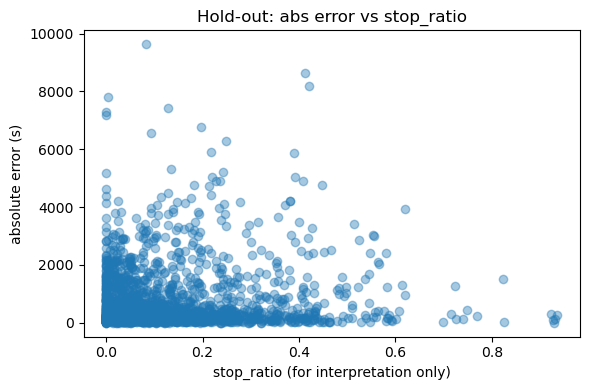

In [12]:
plt.figure(figsize=(6, 4))
plt.scatter(pred_qc["stop_ratio"], pred_qc["abs_error"], alpha=0.4)
plt.xlabel("stop_ratio (for interpretation only)")
plt.ylabel("absolute error (s)")
plt.title("Hold-out: abs error vs stop_ratio")
savefig("33_abs_error_vs_stop_ratio.png")
plt.show()


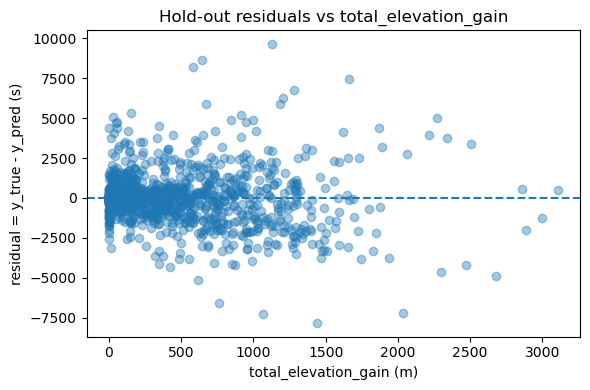

In [13]:
plt.figure(figsize=(6, 4))
plt.scatter(pred_qc["total_elevation_gain"], pred_qc["residual"], alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("total_elevation_gain (m)")
plt.ylabel("residual = y_true - y_pred (s)")
plt.title("Hold-out residuals vs total_elevation_gain")
savefig("34_residuals_vs_elevation_gain.png")
plt.show()


## Zwischenfazit Fehleranalyse (Hold-out)

- Das Modell trifft den Gesamtrend gut (R² ≈ 0.916), aber die Fehlerstreuung steigt mit der Distanz (Heteroskedastizität).
- Hohe Stop-Anteile (`stop_ratio > 0.5`) führen im Mittel zu höheren Fehlern und eher zu Unter­schätzung.
- Große Fehlerfälle treten jedoch auch bei niedriger Stop-Ratio auf → wesentliche Einflussfaktoren (z. B. Fitness, Wind, Untergrund, Verkehr, Gruppendynamik) sind im Feature-Set nicht enthalten.

**Konsequenz für das Projekt:**
- Das Modell ist als baseline-fähige, leakage-sichere Lösung geeignet.
- Für eine Verbesserung werden im nächsten Notebook zusätzliche, leakage-sichere Features und/oder ein flexibleres Modell getestet.


## Fazit Notebook 04 (Hold-out Evaluation)

**Hold-out Performance (NO-LEAK, Poly2 + Ridge):**
- MAE ≈ 752 s (~12.5 min)
- RMSE ≈ 1317 s (~22.0 min)
- R² ≈ 0.916

**Fehlerbild:**
- Die Vorhersage folgt insgesamt eng der Diagonalen (y_true vs y_pred), jedoch steigen Fehler und Streuung mit Distanz und Höhenmetern (Heteroskedastizität).
- Stop-/Pausenverhalten erklärt einen Teil der großen Fehler, ist aber **nicht** der alleinige Treiber.
- Große Fehlfälle treten auch bei niedriger Stop-Ratio auf → wichtige Einflussfaktoren (z. B. Fitness/Leistung, Wind, Untergrund, Verkehr, Gruppendynamik) fehlen im Feature-Set.

**Konsequenz / Next step:**
Im nächsten Notebook werden leakage-sichere Feature-Engineering-Ansätze und mindestens ein flexibleres Tabular-Modell (z. B. Gradient Boosting) getestet, um die Fehler insbesondere bei langen und/oder bergigen Fahrten zu reduzieren.
